# Exploratory Data Analysis with  

In this notebook, we will explore the datasets saved in Amazon S3 by utilizing Apach Spark. We will also try some data analysis ideas to explore the possibility of future analysis that are to be done in data warehouse.  

## Importing Libraries 

In [49]:
import os
import configparser
import pyspark
import datetime
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, udf, unix_timestamp, from_unixtime, year, month, dayofmonth, dayofweek, regexp_replace
from pyspark.sql.types import DateType

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import figure
%matplotlib inline

## Setting Amazon Credentials

In [50]:
config = configparser.ConfigParser()
config.read('dwh.cfg')

os.environ["AWS_ACCESS_KEY_ID"] = config['AWS']['key']
os.environ["AWS_SECRET_ACCESS_KEY"] = config['AWS']['secret']

## Initializing Spark Session

In [51]:
spark = SparkSession \
    .builder \
    .config("spark.jars.packages","org.apache.hadoop:hadoop-aws:2.7.0")\
    .getOrCreate()
spark

## Check the Datasets in S3
Here we will load datasets from S3 and conduct basic data quality checks on each data using a function `check_data`,
which prints the following:
- first couple of rows
- number of rows
- number of duplicate rows
- number of empty rows
- basic statistics of each columns

In [52]:
def check_data(data_name):
    
    table_path = config['SPARK'][data_name]
    
    #Load Data
    print("Loading {} ...".format(data_name))
    table = spark.read.options(inferSchema=True,header=True, sep=',', multiLine=True) \
        .csv(table_path)
    
    # First couple of rows
    print("Printing the forst 3 rows of {}".format(data_name))
    print(table.limit(3).toPandas())
    print("---------------------------------------------------------------------------")
    
    # Row Count
    num_rows = table.count()
    print("Number of rows: {}".format(num_rows))
    
    # Check if there is any duplicate
    duplicate_rows = num_rows - table.dropDuplicates().count()
    print("Duplicate row: {} found".format(duplicate_rows))
    
    # Check if there is any empty row
    empty_rows = num_rows - table.dropna(how='all').count()
    print("Empty row: {} found".format(empty_rows))
    print("---------------------------------------------------------------------------")
    
    # Schema
    print("Printing data schema of {}".format(data_name))
    print(table.printSchema())
    print("---------------------------------------------------------------------------")

    # Basic statistics for each column
    print("Basic statistics of each column of {}".format(data_name))
    for col in table.columns[0:3]:
        table.select(col).describe().show()
    print("============================================================================")


In [53]:
data_names = config['SPARK']
for data_name in data_names:
    check_data(data_name)

Loading liquor_sales_data ...
Printing the forst 3 rows of liquor_sales_data
  Invoice/Item Number        Date  Store Number              Store Name  \
0        S29198800001  11/20/2015          2191          Keokuk Spirits   
1        S29195400002  11/21/2015          2205  Ding's Honk And Holler   
2        S29050300001  11/16/2015          3549    Quicker Liquor Store   

            Address          City Zip Code  \
0         1013 MAIN        KEOKUK    52632   
1  900 E WASHINGTON      CLARINDA    51632   
2      1414 48TH ST  FORT MADISON    52627   

                                      Store Location  County Number County  \
0  1013 MAIN\r\nKEOKUK 52632\r\n(40.39978, -91.38...             56    Lee   
1  900 E WASHINGTON\r\nCLARINDA 51632\r\n(40.7392...             73   Page   
2  1414 48TH ST\r\nFORT MADISON 52627\r\n(40.6242...             56    Lee   

            ...           Item Number  \
0           ...                   297   
1           ...                   297   
2

### Data Visualization
Let's take a look at distributions of some columns. We take 'Iowa Liquor Sales' data for example. We will select some columnms with categorical values for this visualization. We group the rows by the categorical column and get sum of the value of the column 'Volume Sold (Liters)'. This way we can observe the liquor consumption by each county, city, liquor type or vendor name.

In [54]:
filepath = config['SPARK']['liquor_sales_data']
liquor = spark.read.options(inferSchema=True,header=True, sep=',', multiLine=True) \
    .csv(filepath)


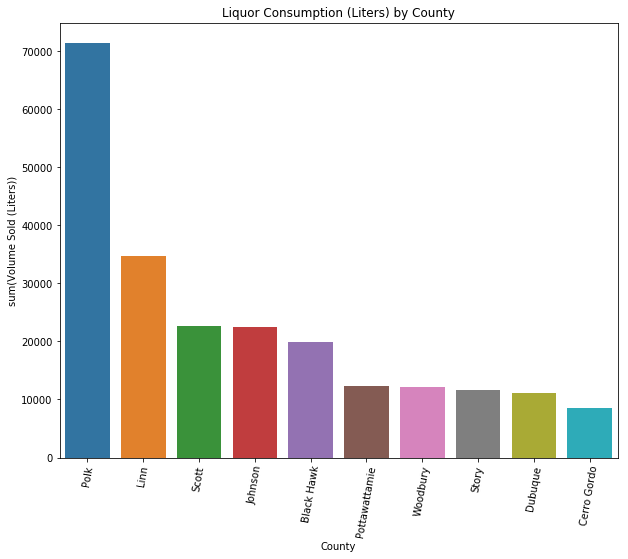

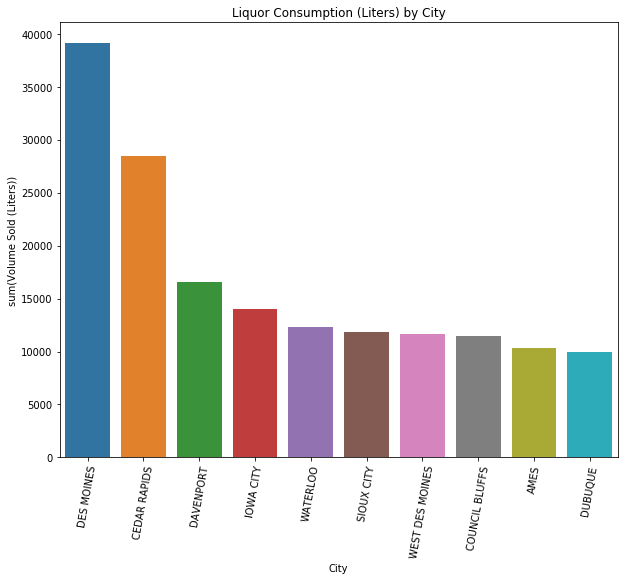

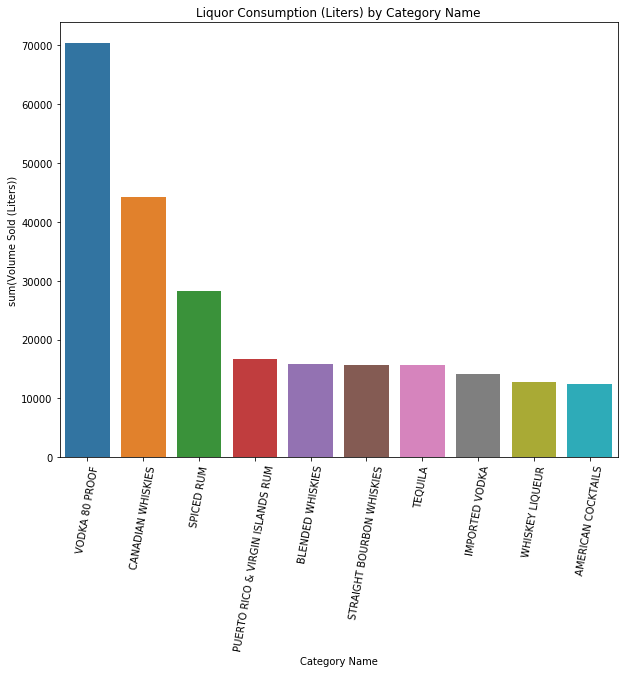

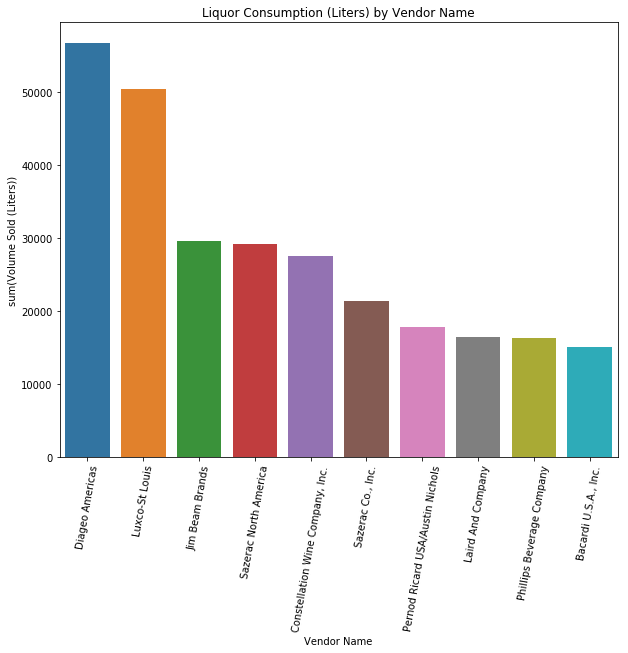

In [55]:
cols = ['County', 'City', 'Category Name', 'Vendor Name']
for col in cols:
    grouped = liquor.groupby(col).sum('Volume Sold (Liters)').orderBy('sum(Volume Sold (Liters))', ascending=False).limit(10).toPandas()
    plt.figure(figsize=(10,8))
    g = sns.barplot(x=grouped[col], y=grouped['sum(Volume Sold (Liters))'])
    g.set_title('Liquor Consumption (Liters) by {}'.format(col))
    g.tick_params(labelsize=10)
    plt.xticks(rotation=80)
    plt.show()

### Time Series


In [56]:
liquor = liquor.withColumn('ts',from_unixtime(unix_timestamp('Date', 'MM/dd/yyyy')))
liquor = liquor.withColumn('year', year('ts')) \
               .withColumn('month', month('ts')) \
               .withColumn('dayofweek', dayofweek('ts'))

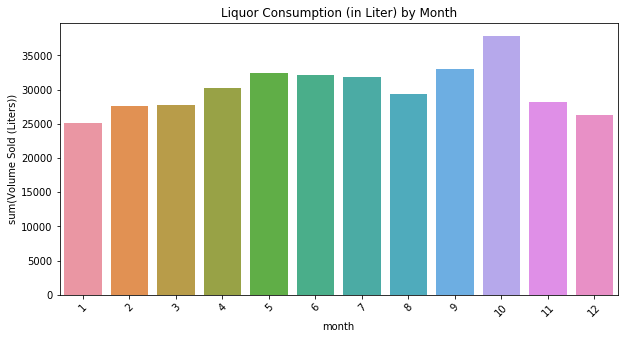

In [57]:
a = liquor.groupby('month').sum('Volume Sold (Liters)').orderBy('month', ascending=True).toPandas()
plt.figure(figsize=(10,5))
g = sns.barplot(x=a['month'], y=a['sum(Volume Sold (Liters))'])
g.set_title("Liquor Consumption (in Liter) by Month")
g.tick_params(labelsize=10)
plt.xticks(rotation=45)
plt.show()

### Joining Tables 
We will join 'liquor_sales_data' with 'county_census_data' to get deeper insight. We will make a joined table using 'County'

In [58]:
filepath = config['SPARK']['county_census_data']
census = spark.read.options(inferSchema=True,header=True, sep=',', multiLine=True)\
    .csv(filepath)

In [59]:
census = census.withColumnRenamed('County', 'County_census')
census = census.withColumn('County_census', regexp_replace('County_census', ' County', ''))
joined = liquor.join(census, (liquor.County == census.County_census) & (census.State == 'Iowa'))

With the joined table, we can now obtain data like liquor consumption **per capita**. 

In [60]:
group = joined.groupby('County', 'TotalPop', 'IncomePerCap').sum('Volume Sold (Liters)')
group = group.withColumn('volume_per_capita', group['sum(Volume Sold (Liters))'] / group['TotalPop'] )\
    .orderBy('volume_per_capita', ascending=False)\
    .limit(10) \
    .toPandas()

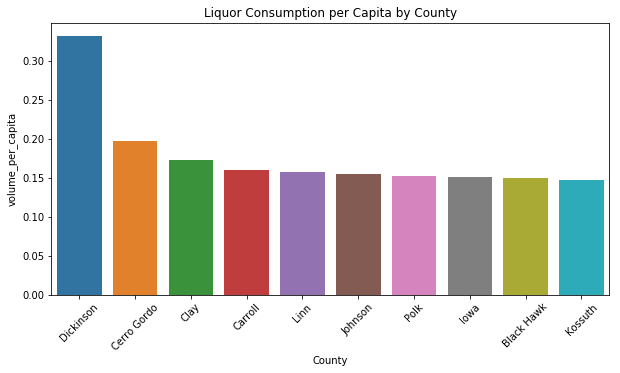

In [61]:
plt.figure(figsize=(10,5))
g = sns.barplot(x=group['County'], y=group['volume_per_capita'])
g.tick_params(labelsize=10)
g.set_title("Liquor Consumption per Capita by County")
plt.xticks(rotation=45)
plt.show()

We can also observe the relation between liquor consumption per capita and the income percapita of the county.

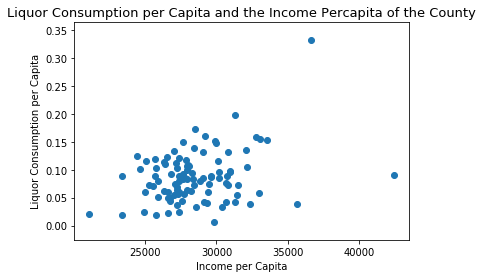

In [62]:
group = joined.groupby('County', 'TotalPop', 'IncomePerCap').sum('Volume Sold (Liters)')
group = group.withColumn('volume_per_capita', group['sum(Volume Sold (Liters))'] / group['TotalPop'] )\
    .orderBy('volume_per_capita', ascending=False)\
    .toPandas()

plt.scatter(x=group['IncomePerCap'], y=group['volume_per_capita'])
plt.title("Liquor Consumption per Capita and the Income Percapita of the County", fontsize=13)
plt.ylabel('Liquor Consumption per Capita', fontsize=10)
plt.xlabel('Income per Capita', fontsize=10)
plt.show()